In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dogs-vs-cats/test1.zip
/kaggle/input/dogs-vs-cats/train.zip
/kaggle/input/dogs-vs-cats/sampleSubmission.csv


In [2]:
# read train.zip dataset and test1.zip dataset
import zipfile as Zip

Zip.ZipFile('/kaggle/input/dogs-vs-cats/train.zip').extractall()
Zip.ZipFile('/kaggle/input/dogs-vs-cats/test1.zip').extractall()

In [3]:
# optimize train dataset
!cd '/kaggle/working/train'; mkdir dogs; mkdir cats

!cd '/kaggle/working/train'; ls | grep -e cat | xargs mv -t cats
!cd '/kaggle/working/train'; ls | grep -e dog | xargs mv -t dogs

mv: cannot move 'cats' to a subdirectory of itself, 'cats/cats'
mv: cannot move 'dogs' to a subdirectory of itself, 'dogs/dogs'


In [4]:
# check train dataset directory
!ls /kaggle/working/train -la

total 1512
drwxr-xr-x 4 root root 761856 Jan 12 01:08 .
drwxr-xr-x 4 root root   4096 Jan 12 01:08 ..
drwxr-xr-x 2 root root 385024 Jan 12 01:08 cats
drwxr-xr-x 2 root root 397312 Jan 12 01:08 dogs


In [5]:
from keras.preprocessing.image import ImageDataGenerator

generator = ImageDataGenerator(rescale = 1/255., validation_split = 0.2)

train_gen = generator.flow_from_directory('/kaggle/working/train', target_size = (64, 64), batch_size = 16, class_mode = 'binary', subset = 'training')
valid_gen = generator.flow_from_directory('/kaggle/working/train', target_size = (64, 64), batch_size = 16, class_mode = 'binary', subset = 'validation')
test_gen = generator.flow_from_directory('/kaggle/working', target_size = (64, 64), batch_size = 16, classes = ['test1'])

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.
Found 12500 images belonging to 1 classes.


In [6]:
# check the shape
x_train, y_train = next(train_gen)
x_test, y_test = next(test_gen)
y_train = y_train.reshape((y_train.shape[0], 1))

x_train.shape, y_train.shape, x_test.shape, y_test.shape

((16, 64, 64, 3), (16, 1), (16, 64, 64, 3), (16, 1))

In [7]:
# build model
from keras.layers import *
from keras.models import *
import numpy as np

def build_model():
    model = Sequential()

    model.add(Conv2D(input_shape = (64, 64, 3), filters = 32, kernel_size = (3, 3), padding = 'same', kernel_initializer = 'he_normal', use_bias = False))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv2D(filters = 32, kernel_size = (3, 3), padding = 'same', kernel_initializer = 'he_normal', use_bias = False))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size = (2, 2))) # pool_size = 전체 크기를 절반으로 줄임

    model.add(Conv2D(filters = 64, kernel_size = (3, 3), padding = 'same', kernel_initializer = 'he_normal', use_bias = False))
    model.add(BatchNormalization())
    model.add(Activation('relu'))   
    model.add(Conv2D(filters = 64, kernel_size = (3, 3), padding = 'same', kernel_initializer = 'he_normal', use_bias = False))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size = (2, 2)))

    model.add(Flatten())
    model.add(Dense(512, activation = 'relu', kernel_initializer = 'he_normal'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation = 'sigmoid', kernel_initializer = 'he_normal'))

    return model

model = build_model()
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 32)        864       
_________________________________________________________________
batch_normalization (BatchNo (None, 64, 64, 32)        128       
_________________________________________________________________
activation (Activation)      (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 32)        9216      
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 64, 32)        128       
_________________________________________________________________
activation_1 (Activation)    (None, 64, 64, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 32)        0

In [8]:
# if val_loss will not imporve consecutive 10 times(patience = 5), epochs will be stopped
from keras.callbacks import EarlyStopping, ModelCheckpoint

es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 5)
mc = ModelCheckpoint('check.h5', monitor = 'val_binary_accuracy', mode = 'max', verbose = 1, save_best_only=True)

In [9]:
from keras.optimizers import SGD

model.compile(loss = 'binary_crossentropy', optimizer = SGD(lr=0.0001, momentum = 0.9, nesterov = True), metrics = ['binary_accuracy'])
history = model.fit(train_gen, epochs = 200, callbacks = [es, mc], batch_size = 8, steps_per_epoch = len(train_gen), validation_data = valid_gen)

Epoch 1/200
1250/1250 [==============================] - ETA: 0s - loss: 0.6587 - binary_accuracy: 0.6340
Epoch 00001: val_binary_accuracy improved from -inf to 0.68440, saving model to check.h5
1250/1250 [==============================] - 65s 52ms/step - loss: 0.6587 - binary_accuracy: 0.6340 - val_loss: 0.5873 - val_binary_accuracy: 0.6844
Epoch 2/200
1250/1250 [==============================] - ETA: 0s - loss: 0.5784 - binary_accuracy: 0.6906
Epoch 00002: val_binary_accuracy improved from 0.68440 to 0.71660, saving model to check.h5
1250/1250 [==============================] - 64s 51ms/step - loss: 0.5784 - binary_accuracy: 0.6906 - val_loss: 0.5494 - val_binary_accuracy: 0.7166
Epoch 3/200
1249/1250 [============================>.] - ETA: 0s - loss: 0.5415 - binary_accuracy: 0.7218
Epoch 00003: val_binary_accuracy improved from 0.71660 to 0.73460, saving model to check.h5
1250/1250 [==============================] - 64s 51ms/step - loss: 0.5416 - binary_accuracy: 0.7216 - val_loss:

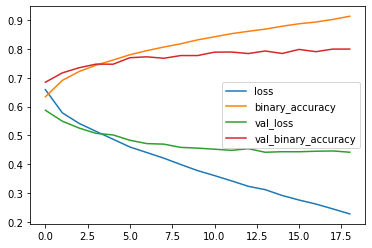

In [10]:
# check result on graph
import matplotlib.pyplot as plt

loss = history.history['loss']
acc = history.history['binary_accuracy']
val_loss = history.history['val_loss']
val_acc = history.history['val_binary_accuracy']

plt.plot(loss, label= 'loss')
plt.plot(acc, label= 'binary_accuracy')
plt.plot(val_loss, label= 'val_loss')
plt.plot(val_acc, label= 'val_binary_accuracy')

plt.legend()
plt.show()